In [1]:
import requests
import pandas as pd
from vega_datasets import data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import prepare
import modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LassoLars
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('mfsnowcrab.csv')

In [3]:
df = df[df['cpue'] < 2000000]

In [4]:
df['year'] = pd.to_datetime(df['year'], format = '%Y')
df.dtypes

id                              int64
latitude                      float64
longitude                     float64
year                   datetime64[ns]
name                           object
sex                            object
bottom_depth                    int64
surface_temperature           float64
bottom_temperature            float64
haul                            int64
cpue                            int64
dtype: object

In [5]:
df_time = df[['year','cpue']]

In [6]:
df_time.head()

,year,cpue
0,1975-01-01,40356
1,1975-01-01,68691
2,1975-01-01,119748
3,1975-01-01,7882
4,1975-01-01,11258


In [7]:
df_time.shape

(17920, 2)

In [8]:
df_time = df_time.set_index('year')
df_time = df_time.sort_index()
df_time.head()

,cpue
year,
1975-01-01,40356
1975-01-01,314659
1975-01-01,258993
1975-01-01,1717
1975-01-01,4491


In [9]:
df_time = df_time.resample('y')['cpue'].mean()
df_time.shape

(44,)

In [10]:
train_len = int(0.6 *len(df_time))
val_test_split = int(0.8 * len(df_time))
train_len, val_test_split

(26, 35)

In [11]:
train = df_time.iloc[:train_len]
val = df_time.iloc[train_len: val_test_split]
test = df_time.iloc[val_test_split:]
train.shape, val.shape, test.shape

((26,), (9,), (9,))

In [76]:
train = pd.DataFrame(train)
val = pd.DataFrame(val)
test = pd.DataFrame(test)

In [13]:
val.head()

,cpue
year,
2001-12-31,19383.346939
2002-12-31,8276.072289
2003-12-31,15836.513158
2004-12-31,28370.948980
2005-12-31,35029.108466


<AxesSubplot:xlabel='year'>

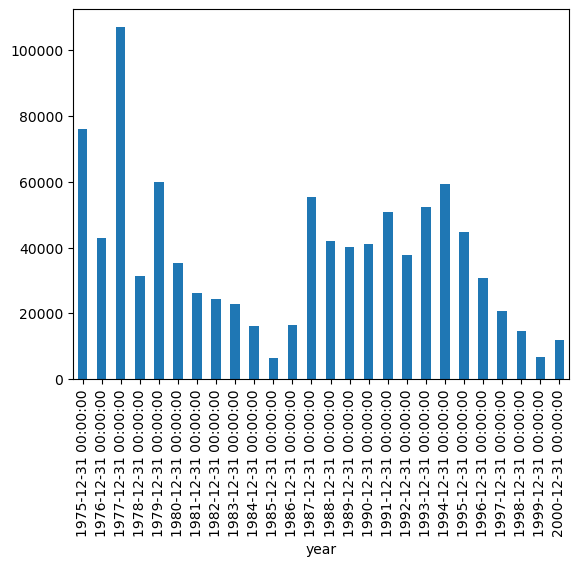

In [14]:
train.groupby('year')['cpue'].sum().plot.bar()

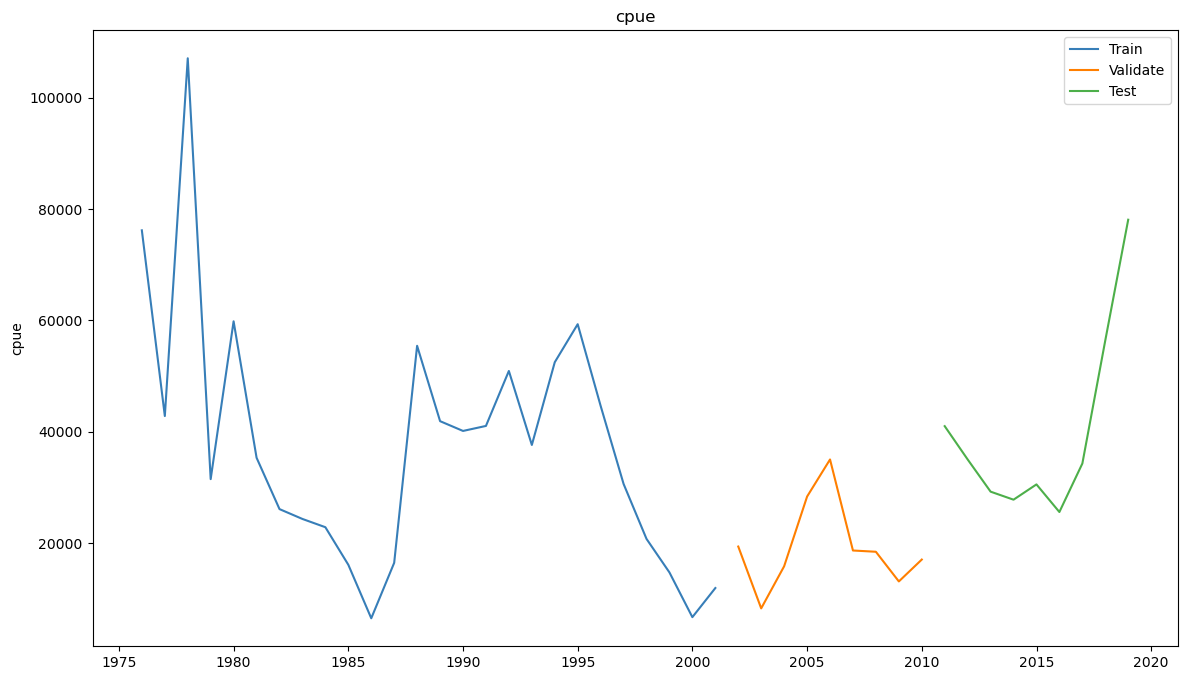

In [15]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(val[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [16]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


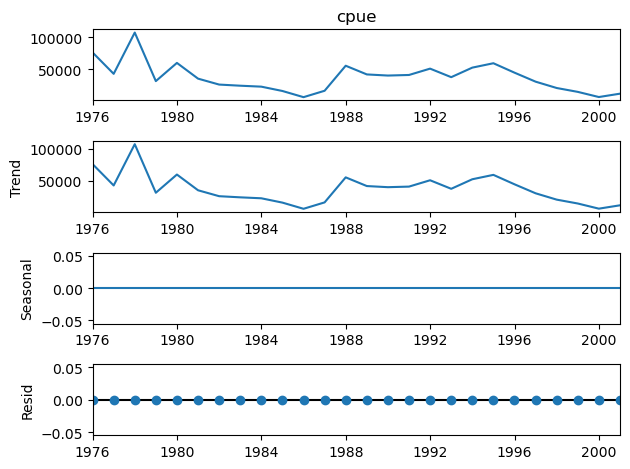

In [17]:
sm.tsa.seasonal_decompose(train['cpue'].resample('1y').mean()).plot()
None

In [18]:
baseline = round(train['cpue'].mean(), 4)

In [19]:
baseline

37446.3814

In [20]:
yhat_df = modeling.make_baseline_predictions(baseline, val)

In [21]:
yhat_df.head()

,cpue
year,
2001-12-31,37446.3814
2002-12-31,37446.3814
2003-12-31,37446.3814
2004-12-31,37446.3814
2005-12-31,37446.3814


cpue -- RMSE: 19589


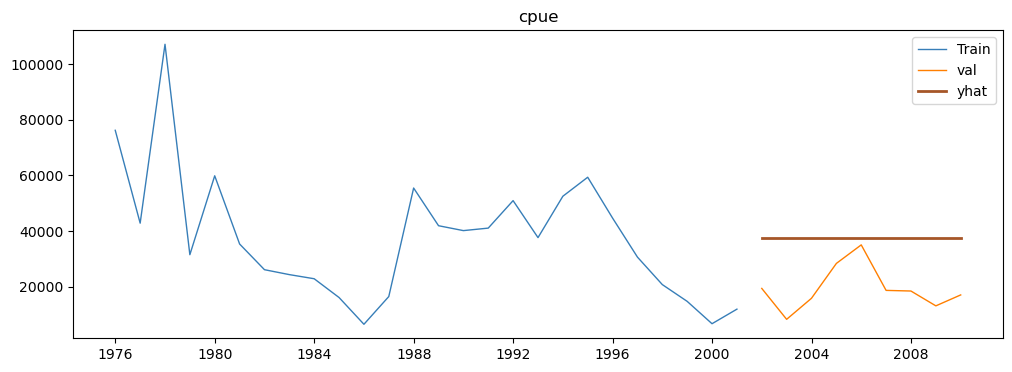

In [22]:
modeling.plot_and_eval('cpue', train, val, yhat_df)

In [23]:
eval_df = modeling.append_eval_df('simple_mean', col, val, yhat_df, eval_df)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.0


In [24]:
hst_cpue = ExponentialSmoothing(train.cpue, seasonal_periods=9, 
                                trend='add', seasonal='add', damped = True).fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [25]:
hst_preds = hst_cpue.forecast(val.shape[0])

In [26]:
hst_preds[hst_preds < 0] = 0

In [27]:
yhat_df = pd.DataFrame({'cpue': hst_preds},
                          index=val.index)
yhat_df.head(20)

,cpue
year,
2001-12-31,9719.304090
2002-12-31,11562.712610
2003-12-31,0.000000
2004-12-31,7646.477973
2005-12-31,23348.488916
2006-12-31,18300.495821
2007-12-31,5686.491305
2008-12-31,0.000000
2009-12-31,7160.516796


cpue -- RMSE: 12265


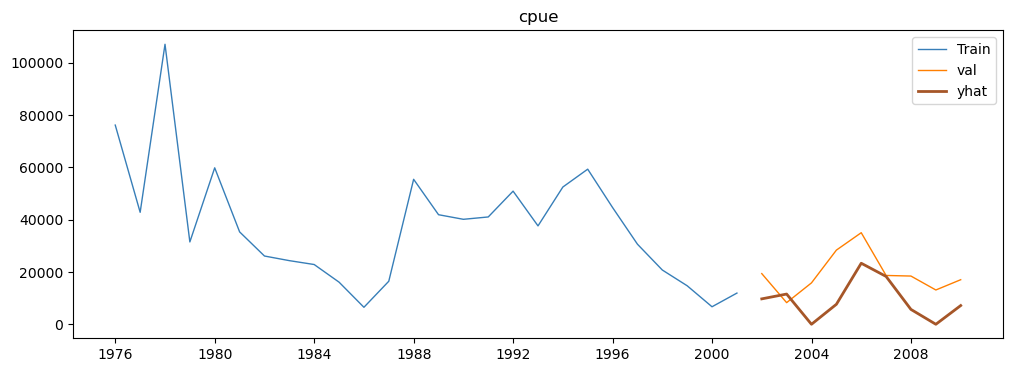

In [28]:
modeling.plot_and_eval(col, train, val, yhat_df)

In [29]:
eval_df = modeling.append_eval_df('holts_seasonal', col, val, yhat_df, eval_df)

In [30]:
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.0
1,holts_seasonal,cpue,12265.0


In [31]:
reg_df = pd.read_csv('mfsnowcrab.csv')

In [32]:
reg_df = reg_df[reg_df['cpue'] < 2000000]
reg_df.drop(columns = ['id','name','haul'], inplace = True)

In [33]:
reg_df = pd.get_dummies(reg_df, columns = ['sex','year'], drop_first = [True, True])

In [34]:
train_reg, val_reg, test_reg = modeling.train_val_test(reg_df)

In [35]:
to_scale = ['latitude', 'longitude','bottom_depth','surface_temperature','bottom_temperature']
mm_scaler = MinMaxScaler()
for col in to_scale:
    mm_scaler.fit(train_reg[[col]])
    train_reg[col] = mm_scaler.transform(train_reg[[col]])
    val_reg[col] = mm_scaler.transform(val_reg[[col]])
    test_reg[col] = mm_scaler.transform(test_reg[[col]])

In [36]:
train_reg.head()

,latitude,longitude,bottom_depth,surface_temperature,bottom_temperature,cpue,sex_male,year_1976,year_1977,year_1978,...,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
4224,0.495810,0.621912,0.078740,0.342105,0.454545,77,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1303,0.406397,0.717931,0.106299,0.289474,0.280992,21400,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9406,0.269787,0.346604,0.374016,0.506579,0.396694,3413,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6165,0.490558,0.235434,0.374016,0.730263,0.380165,84660,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1646,0.293898,0.421145,0.200787,0.526316,0.652893,3281,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
x_train = train_reg.drop(columns = 'cpue')
y_train = train_reg['cpue']
x_val = val_reg.drop(columns = 'cpue')
y_val = val_reg['cpue']
x_test = test_reg.drop(columns = 'cpue')
y_test = test_reg['cpue']

In [38]:
lasso = LassoLars(alpha = 1)

In [39]:
lasso.fit(x_train, y_train)

LassoLars(alpha=1)

In [40]:
preds_df = pd.DataFrame(train_reg['cpue'])

In [41]:
preds_df.head()

,cpue
4224,77
1303,21400
9406,3413
6165,84660
1646,3281


In [42]:
lasso_preds = lasso.predict(x_train)

In [43]:
lasso_preds[lasso_preds < 0] = 0

In [44]:
preds_df['baseline'] = preds_df['cpue'].mean()

In [45]:
preds_df['lasso_preds'] = lasso_preds

In [46]:
preds_df.head()

,cpue,baseline,lasso_preds
4224,77,31652.13648,50880.933730
1303,21400,31652.13648,34185.261147
9406,3413,31652.13648,0.000000
6165,84660,31652.13648,47969.528861
1646,3281,31652.13648,478.587982


In [47]:
lasso_rmse = sqrt(mean_squared_error(preds_df['lasso_preds'], preds_df['cpue']))

In [48]:
eval_df = eval_df.append({'model_type':'Lasso_Lars', 'target_var':'cpue','rmse':lasso_rmse}, ignore_index=True)



In [49]:
tweedie = TweedieRegressor(power = 1, alpha = 1)

In [50]:
tweedie.fit(x_train, y_train)

TweedieRegressor(alpha=1, power=1)

In [51]:
tweedie_preds = tweedie.predict(x_train)

In [52]:
tweedie_preds[tweedie_preds < 0] = 0

In [53]:
preds_df['tweedie'] = tweedie_preds
preds_df.head()

,cpue,baseline,lasso_preds,tweedie
4224,77,31652.13648,50880.933730,33885.844480
1303,21400,31652.13648,34185.261147,19989.219846
9406,3413,31652.13648,0.000000,2052.030987
6165,84660,31652.13648,47969.528861,35218.111781
1646,3281,31652.13648,478.587982,13400.116563


In [54]:
tweedie_rmse = sqrt(mean_squared_error(preds_df['tweedie'], preds_df['cpue']))

In [55]:
eval_df = eval_df.append({'model_type':'Tweedie', 'target_var':'cpue','rmse':tweedie_rmse}, ignore_index=True)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.000000
1,holts_seasonal,cpue,12265.000000
2,Lasso_Lars,cpue,85038.968993
3,Tweedie,cpue,83310.556760


In [56]:
pf = PolynomialFeatures(degree = 2)

In [57]:
pf.fit(x_train, y_train)

PolynomialFeatures()

In [58]:
x_poly=pf.transform(x_train)

In [59]:
lm = LinearRegression()

In [60]:
lm.fit(x_poly, y_train)

LinearRegression()

In [61]:
poly_preds = lm.predict(x_poly)

In [62]:
poly_preds[poly_preds < 0] = 0

In [63]:
preds_df['poly_preds'] = poly_preds
preds_df.head()

,cpue,baseline,lasso_preds,tweedie,poly_preds
4224,77,31652.13648,50880.933730,33885.844480,11154.0
1303,21400,31652.13648,34185.261147,19989.219846,11442.0
9406,3413,31652.13648,0.000000,2052.030987,0.0
6165,84660,31652.13648,47969.528861,35218.111781,54546.0
1646,3281,31652.13648,478.587982,13400.116563,67730.0


In [64]:
poly_rmse = sqrt(mean_squared_error(preds_df['poly_preds'], preds_df['cpue']))

In [65]:
eval_df = eval_df.append({'model_type':'Poly_Reg', 'target_var':'cpue','rmse':poly_rmse}, ignore_index=True)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.000000
1,holts_seasonal,cpue,12265.000000
2,Lasso_Lars,cpue,85038.968993
3,Tweedie,cpue,83310.556760
4,Poly_Reg,cpue,79415.132597


In [67]:
train, val, test = modeling.split_time(df_time)

In [100]:
test.head(1)

,cpue
year,
2010-12-31,41014.978903


In [71]:
#generates the test predictions

yhat_df = pd.DataFrame({'cpue': hst_cpue.forecast(val.shape[0] + test.shape[0])})

In [90]:
yhat_df=yhat_df['2010-12-31':'2018-12-31']

In [91]:
yhat_df

,cpue
2010-12-31,1317.450392
2011-12-31,3244.877449
2012-12-31,-9290.818744
2013-12-31,-505.832268
2014-12-31,15277.701778
2015-12-31,10310.416554
2016-12-31,-2223.687169
2017-12-31,-7907.004975
2018-12-31,-592.249126


In [92]:
test.tail

<bound method NDFrame.tail of                     cpue
year                    
2010-12-31  41014.978903
2011-12-31  35039.924051
2012-12-31  29246.130165
2013-12-31  27805.177677
2014-12-31  30548.936681
2015-12-31  25589.697727
2016-12-31  34304.579208
2017-12-31  56421.875989
2018-12-31  78104.202564>

In [93]:
rmse_temp_total = sqrt(mean_squared_error(test['cpue'], yhat_df['cpue']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-temp total:  43468.69397315249


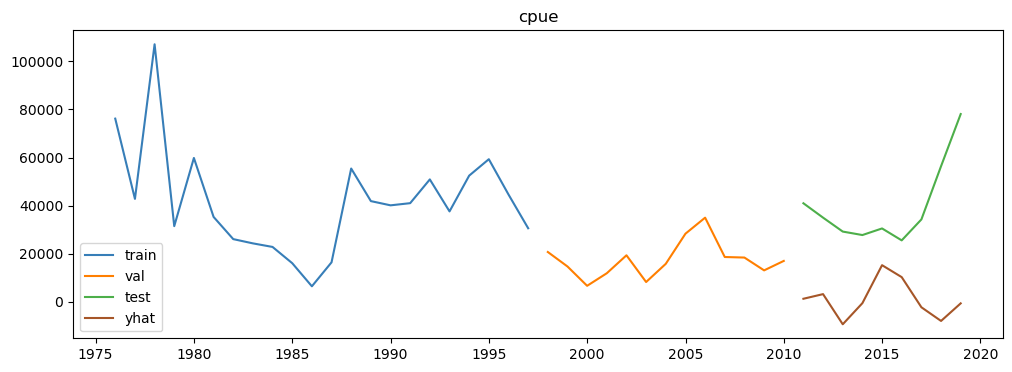

In [95]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-temp total: ', rmse_temp_total)
modeling.final_plot('cpue', train, val, test, yhat_df)